<a href="https://colab.research.google.com/github/OscarBedford/DL_Course/blob/main/ECSE552_W23_H3_G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE552 - W22 - Homework 3
Released: 11 March 2023

Due: 30 March 2023

Last Modified: 11 March 2023

---

For questions please contact:


Part 1 - Joseph Szymborski (`joseph.szymborski@mail.mcgill.ca`)

Part 2 - David Hostallero (`david.hostallero@mail.mcgill.ca`)



In [2]:
!curl -O https://gist.githubusercontent.com/jszym/479db2af32411b64249bfb1bff43a95e/raw/1bef32b78e6ddd414beebe6e57cf3b0a0fac44ea/dictlogger.py
from dictlogger import DictLogger

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1610  100  1610    0     0  11418      0 --:--:-- --:--:-- --:--:-- 11338


In [3]:
import matplotlib
font = {'weight' : 'regular',
        'size'   : 22}

matplotlib.rc('font', **font)

In [4]:
%%capture
!pip install pip install umap-learn
!pip install pytorch-lightning
import tarfile
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import umap
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

# Part 1 - Conditional Variational Autoencoders

### Introduction

Conditional Variational Autoencoders (CVAEs) are an extension of Variational Autoencoders (VAEs).

As we explored in tutorial eight, VAEs are comprised of two main parts: an encoder and a decoder.

The encoder approximates the function $Q(z|X)$ and the decoder approximates the function $P(X|z)$.

As a reminder, here $X$ is the input data and $z$ is a latent vector.

For more details, you might consider this [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908) by Carl Doersch.

The above formulation, however, does not allow us to generate specific images. For example, given a model trained on the MNIST digits, it's difficult to fully explore the latent space for a given digit.

We can solve this by conditioning $P$ by not only the latent vector $z$, but some value $c$ that can encode information, (_e.g._: which MNIST digit we're generating).

This would mean our decoder would got from $P(X|z)$ in the VAE case to $P(X|z,c)$ in the CVAE case.

### Practical Implementation

Practically, this means that a "conditional" vector $c$ is passed to the decoder. This is commonly a class label for the sample that is one-hot encoded, but it can be anything you wish to marginalise the model by.

Below is a very high-level illustration of both a Variational Autoencoder (VAE) and a Conditional Variational Autoencoder (CVAE). Components of the CVAE that are not present in the VAE are demarked with a yellow star.

The CVAE is identical to the VAE, but for the concatenation of the vector $c$ to the vector $z$ before being inputted into the decoder. The loss function does not change in any way.

In this diagram the dimensions are noted for all the inputs and outputs of the Encoder and Decoder.

The dimension variables are as follows:

* $m$ is the batch size
* $w$ is the width of the image inputted into our encoder
* $h$ is the height of the image inputted into our encoder
* $n$ is the number of latent variables
* $q$ is the width of the conditional vector. If $c$ represents the class of the image, then $q$ is often equal to the number of classes.

![VAE vs CVAE](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/vae_cvae.webp)

Let's look closer at the concatenation of $z$ and $c$, as well as the representation of $c$. Consider the case of a CVAE where the samples are MNIST digits and $c$ is the one-hot encoded class of the digit. In this example, the number of latent variables ($n$ in the diagram above) is 3. Below is an illustration of what the concatenation might look like.

![Concatenating z with c](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/conditional_z.webp)

The vectors that are the result of concatenating $z$ and $c$ (let's call it $z_c$) then become the input to the decoder.

### Q1.1 - Implementing an MNIST CVAE (26 pts)

Your task is to extend the MNIST VAE from Tutorial 8 to a CVAE.

Specifically, you must:

1. Correctly define a conditional vector $c$ in the training loop.
2. Correctly concatenate it to $z$ to form $z_c$.
3. Input $z_c$ to the Decoder.
4. Make any further nescessary modifications to the code.

You are provided with the complete code for the MNIST VAE presented in Tutorial 8, including data loaders, encoders, decoders, and training/validation loops.

The number of latent variables for this excercise ($n$) is set to 10.

**Hint**: While you are permitted to make changes to the Encoder and Decoder class, it is not nescessary to correctly answer this question.

**Another Hint**: You can correctly answer this question by modifying/adding no more than six lines.

In [5]:
class MNISTDataset(Dataset):

    def __init__(self, csv_path):

        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        return torch.tensor(self.df.iloc[idx][1:])/255, self.df.iloc[idx][0]

In [6]:
batch_size = 100

dataset = MNISTDataset('./sample_data/mnist_train_small.csv')

num_test = len(dataset) // 10
num_train = len(dataset) - num_test
dataset_train, dataset_test = random_split(dataset, [num_train, num_test])

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super(Encoder, self).__init__()

        self.layer0 = nn.Linear(in_dim, 1024)
        self.layer1 = nn.Linear(512, 768)
        self.layer2 = nn.Linear(768, 1024)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(128, latent_dim)

        self.pool = nn.MaxPool1d(2)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x, y):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(x)
        x = x.reshape(x.shape[0], x.shape[2])

        x = self.layer4(x)
        x = self.activation(x)

        return x

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super(Decoder, self).__init__()

        self.layer4 = nn.Linear(784, out_dim)
        self.layer3 = nn.Linear(768, 784)
        self.layer2 = nn.Linear(1024, 768)
        self.layer1 = nn.Linear(256, 1024)
        self.layer0 = nn.Linear(latent_dim, 256)

        self.dropout = nn.Dropout(0.3)

        self.activation = nn.LeakyReLU(0.01)

    def forward(self, x):

        x = self.layer0(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer1(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer2(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer3(x)
        x = self.activation(x)

        x = self.dropout(x)

        x = self.layer4(x)
        x = torch.sigmoid(x)

        return x

In [9]:
class MNIST_VAE(pl.LightningModule):
    def __init__(self, in_dim, out_dim, latent_dim):
        super(MNIST_VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = Encoder(in_dim, latent_dim*2)
        self.decoder = Decoder(latent_dim + 10, out_dim) #latent_dim + one-hot encoded class of the digit
        self.recon_criterion = nn.BCELoss(reduction='sum')

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 

    def loss(self, mu, logvar, pred, target):

        kld_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
        recons_loss = self.recon_criterion(pred, target)

        loss = recons_loss + kld_loss

        return kld_loss, recons_loss, loss

    def forward(self, x, y):

        parameters= self.encoder(x,y)

        mu = parameters[:, :self.latent_dim]
        logvar = parameters[:, self.latent_dim:]

        z = self.reparameterize(mu, logvar)
        c = F.one_hot(y, num_classes=10)

        x_hat = self.decoder(torch.cat((z, c), 1))

        return mu, logvar, z, x_hat

    def training_step(self, batch, batch_idx):

        x, y = batch
        
        mu, logvar, z, x_hat = self(x,y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('training_loss', loss, on_step=False, on_epoch=True)
        self.log('training_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('training_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):

        x, y = batch

        mu, logvar, z, x_hat = self(x,y)

        kld_loss, recons_loss, loss = self.loss(mu, logvar, x_hat, x)

        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_kld_loss', kld_loss, on_step=False, on_epoch=True)
        self.log('val_recons_loss', recons_loss, on_step=False, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(dataloader_train), epochs=20)
        return [optimizer], [scheduler]

In [10]:
model = MNIST_VAE(784, 784, 10)

In [11]:
logger = DictLogger()
early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=0.0001, 
                               patience=3)
trainer = pl.Trainer(accelerator='gpu', devices=1,logger=logger, callbacks=[early_stopping],
                     max_epochs=40)


trainer.fit(model, dataloader_train, dataloader_test)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type    | Params
--------------------------------------------
0 | encoder         | Encoder | 2.1 M 
1 | decoder         | Decoder | 2.3 M 
2 | recon_criterion | BCELoss | 0     
--------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.573    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 20470.441


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2016.156 >= min_delta = 0.0001. New best score: 18454.285


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1185.035 >= min_delta = 0.0001. New best score: 17269.250


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 449.510 >= min_delta = 0.0001. New best score: 16819.740


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 335.084 >= min_delta = 0.0001. New best score: 16484.656


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 341.486 >= min_delta = 0.0001. New best score: 16143.170


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 148.637 >= min_delta = 0.0001. New best score: 15994.533


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 299.426 >= min_delta = 0.0001. New best score: 15695.107


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 164.622 >= min_delta = 0.0001. New best score: 15530.485


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 201.962 >= min_delta = 0.0001. New best score: 15328.523


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 131.537 >= min_delta = 0.0001. New best score: 15196.986


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 207.609 >= min_delta = 0.0001. New best score: 14989.377


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 269.738 >= min_delta = 0.0001. New best score: 14719.639


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 184.859 >= min_delta = 0.0001. New best score: 14534.779


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 146.959 >= min_delta = 0.0001. New best score: 14387.820


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 76.675 >= min_delta = 0.0001. New best score: 14311.146


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 50.301 >= min_delta = 0.0001. New best score: 14260.845


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 163.729 >= min_delta = 0.0001. New best score: 14097.115


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 14097.115. Signaling Trainer to stop.


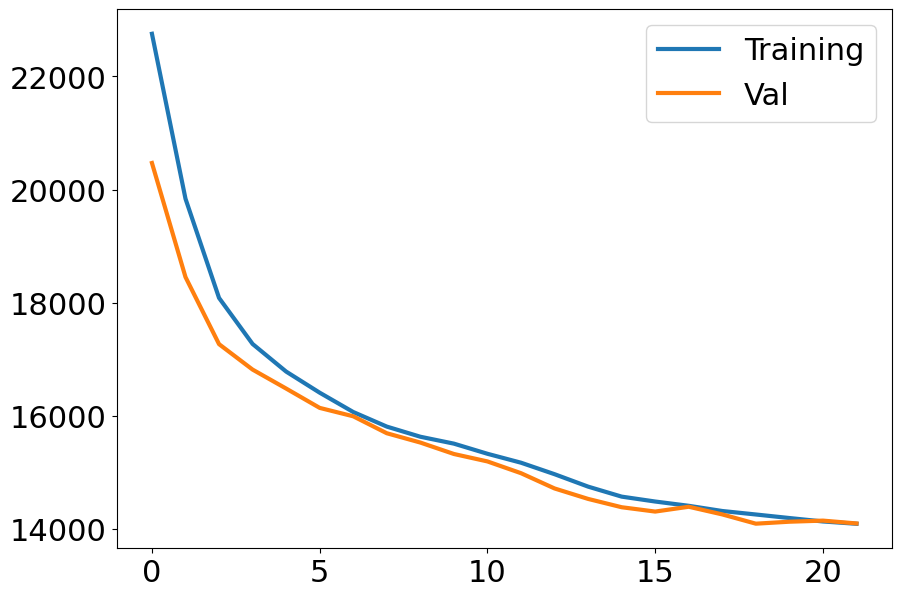

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(logger.metrics['training_loss'], label='Training', lw=3)
plt.plot(logger.metrics['val_loss'], label='Val', lw=3)
plt.legend()
plt.show()

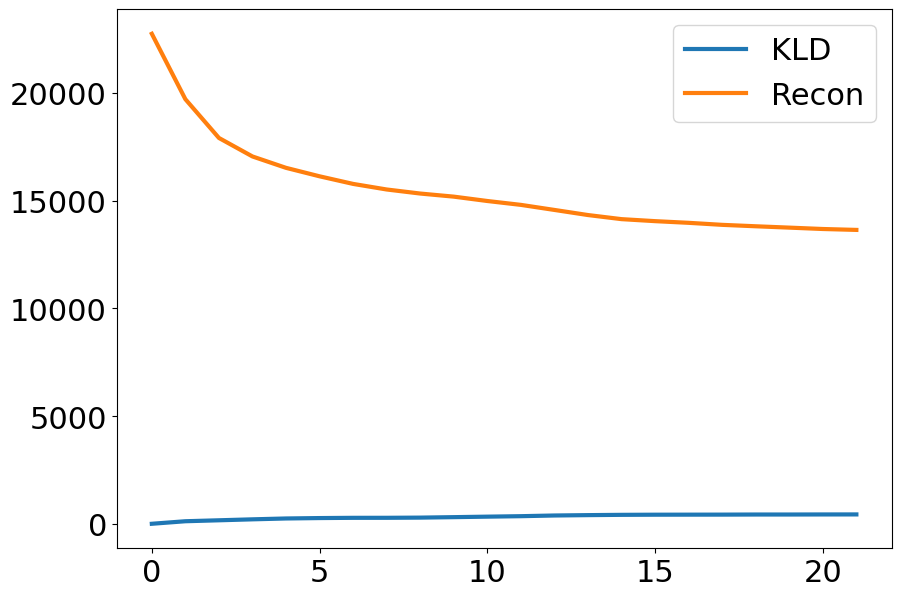

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(logger.metrics['training_kld_loss'], label='KLD', lw=3)
plt.plot(logger.metrics['training_recons_loss'], label='Recon', lw=3)
plt.legend()
plt.show()

### Q1.2 Demonstrate Reconstruction (11 pts)

In the same way as was demonstrated in Tutorial 8, the ability of your model to reconstruct the first two digits from the first batch provided by `dataloader_test`. 

Specifically, pass the first two values of `x` and `y` from `dataloader_test` to `model` and reconstruct these images. Plot them as illustrated below:

![Reconstructed MNIST digits](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/q1.2.webp)

**Note**: The batches are randomised so you won't nescessarily get the same samples shown above.

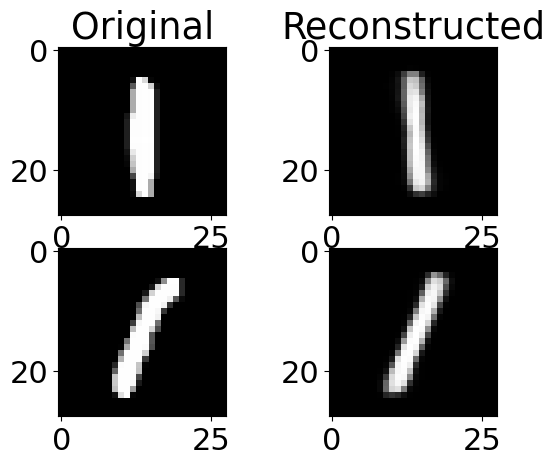

In [14]:
# Q1.2 Code Here
batch = iter(dataloader_test)
(x, y) = next(batch)
x = x.view(-1,28*28)
test_out = model(x, y)
mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)
ax[0, 0].set_title('Original')
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed')
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[1].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[1].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.3 Demonstrate Conditional Reconstruction (13 pts)

Similar to Q1.2, reconstruct digits, but instead of using the correct $c$ vector, change the class label to a different one.

For example, the value of `y` for the two samples below are 3 and 6, but when reconstructing, the $c$ vector `[0,0,1,0,0,0,0,0,0,0]` was supplied.

![Conditioned Reconstruction](https://s3.ca-central-1.wasabisys.com/dl.szymborski.ca/ecse552/W22/H3/q1.3.png)

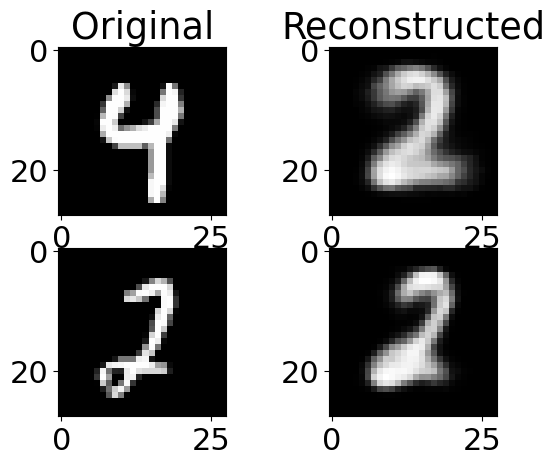

In [15]:
# Q1.3
batch = iter(dataloader_test)
(x, y) = next(batch)
x = x.view(-1,28*28)
y1 = torch.full(y.shape, 2)
test_out = model(x, y1)
mu, logvar, z, x_hat = test_out

fig, ax = plt.subplots(2,2)
ax[0, 0].set_title('Original')
ax[0, 0].imshow(x[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[0, 1].set_title('Reconstructed')
ax[0, 1].imshow(x_hat[0].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

ax[1, 0].imshow(x[1].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')
ax[1, 1].imshow(x_hat[1].reshape(28,28).cpu().detach().numpy(), cmap='Greys_r')

### Q1.4 Explore the Latent Space (26 pts)

We now wish to traverse the latent space by individually sweeping each latent variable within a standard deviation. By doing so with a fixed value of $c$, we can better understand what individual latent variables encode for with regard to a specific digit.

Specifically, your task is to:

1. Calculate the mean ($\mu$) of latent vectors `z` from one batch provided by `dataloader_test`
2. Calculate the stdev ($\sigma$) of latent vectors `z` from one batch provided by `dataloader_test`
3. For each combination of $i \in [1\dots n]$ and $j \in [1\dots10]$:
    1. Create a [clone](https://pytorch.org/docs/stable/generated/torch.Tensor.clone.html#torch.Tensor.clone) of the $\mu$ vector named $z^{*(i,j)}$
    2. Calculate $\delta = \frac{(\mu+2\sigma) - (\mu - 2\sigma)}{9}$
    3. Make the $i$th element of $z^{*(i,j)}$ equal to $\mu_i-2\sigma_i + \delta_i \times j$ 
    4. Input into our model's decoder the latent vector $z^{*(i,j)}$ 
  and a $c$ vector that encodes for the number 2 to create an image $\hat{x}^{*(i,j)}$
4. Plot every $\hat{x}^{*(i,j)}$ in a $10\times10$ grid, where each row is a different value of $i$, and each column is a different value of $j$

Recall, $n$ is the number of latent variables.

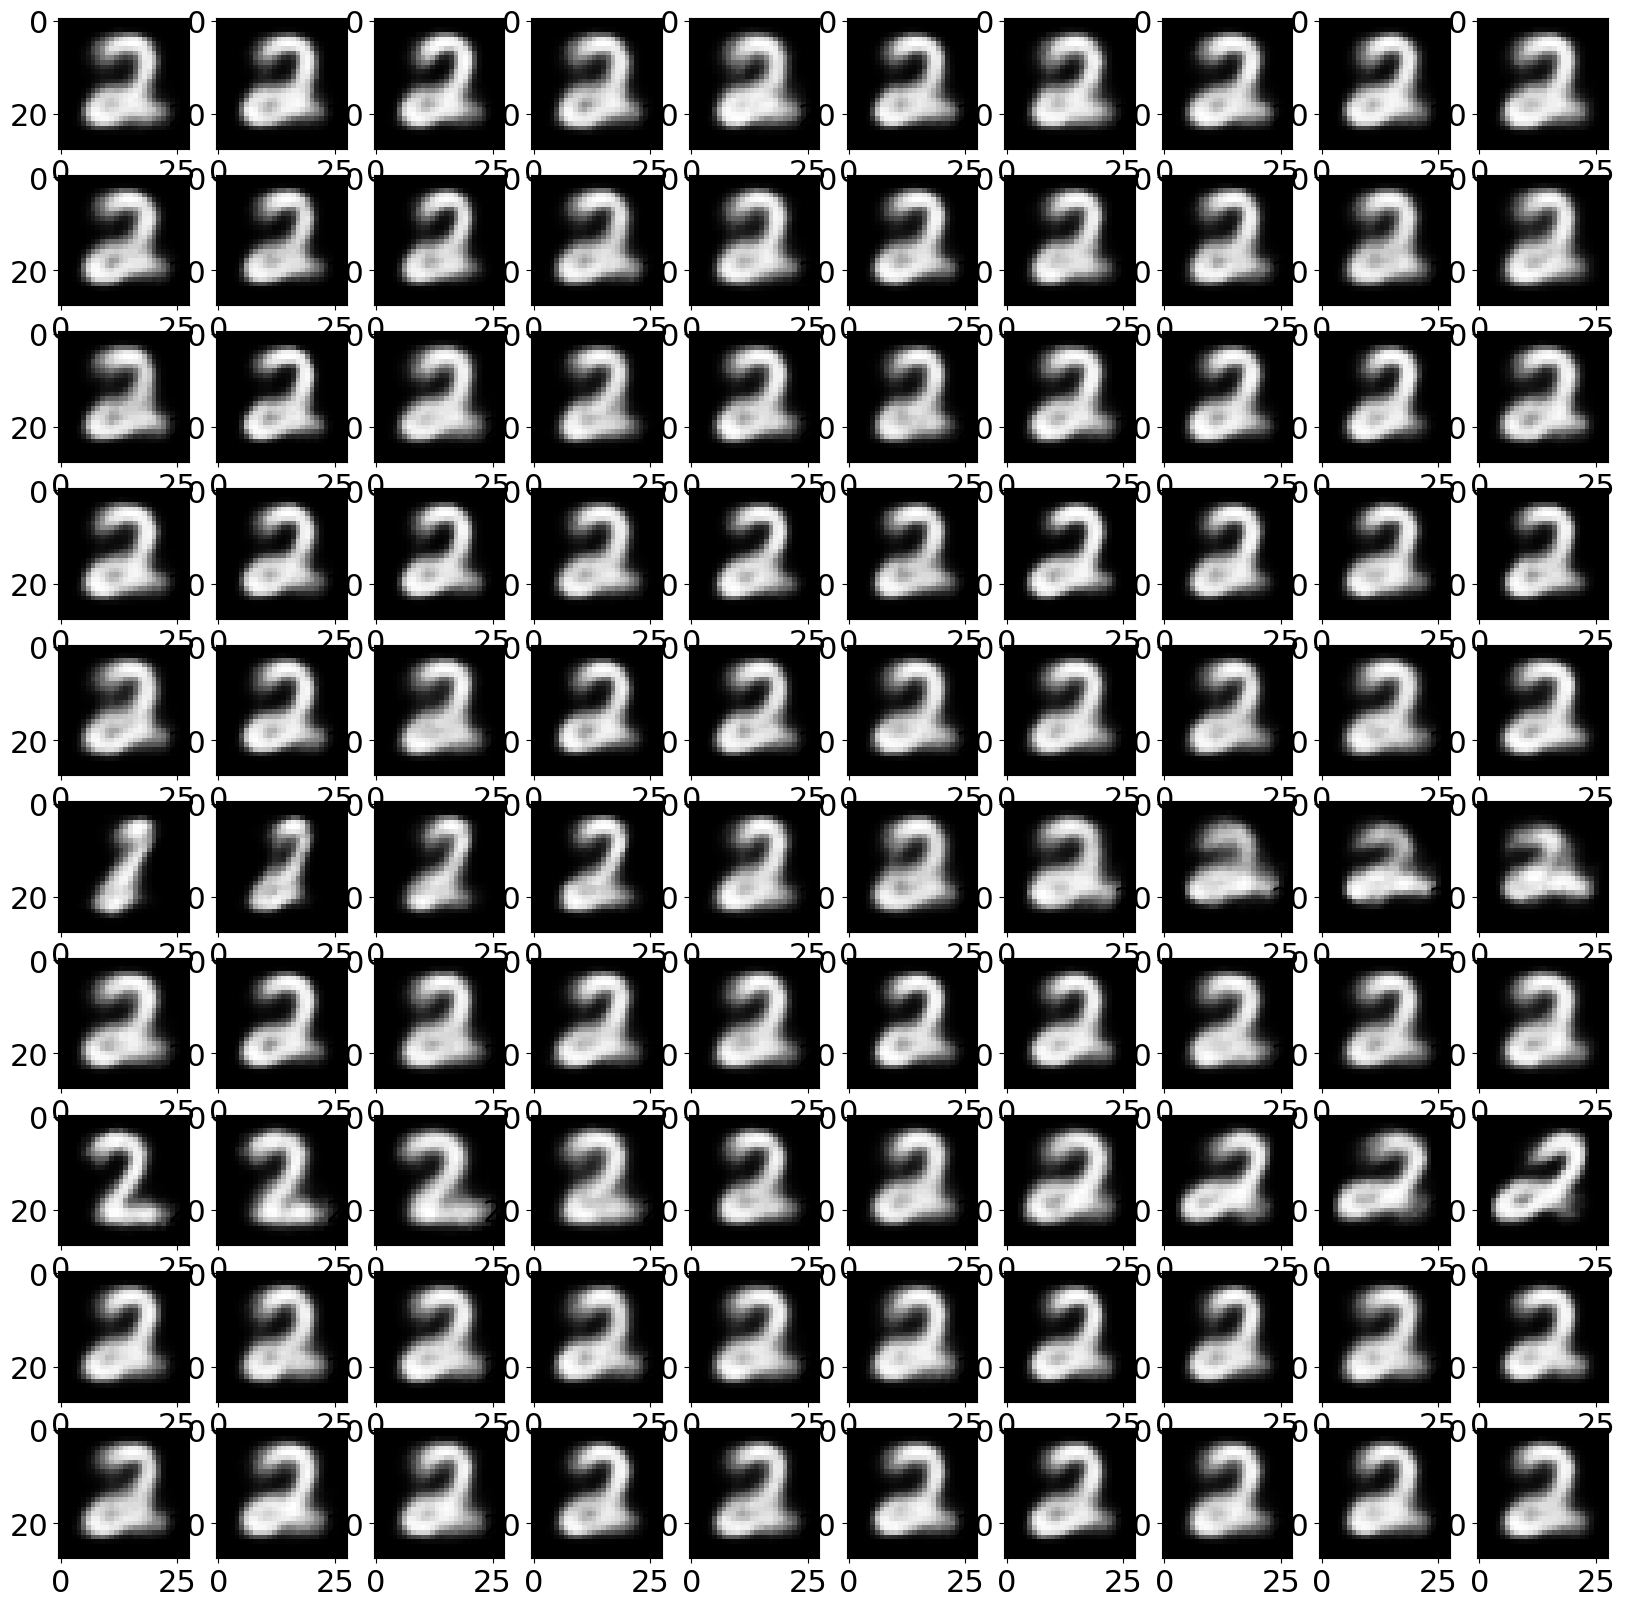

In [16]:
# Q1.4 Code Here
mu, std = torch.mean(z, dim=0).detach(), torch.std(z, dim=0).detach()

delta = ((mu+2*std) - (mu-2*std))/9

c = torch.tensor([0,0,1,0,0,0,0,0,0,0])

fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(len(mu)):

  for j in range(10):
    z_ij = torch.clone(mu)
    z_ij[i] = mu[i] - 2*std[i] + delta[i]*j

    input = torch.cat((z_ij, c), 0)
    recon = model.decoder(input).detach().numpy().reshape((28, 28))
    ax[i, j].imshow(recon, cmap='Greys_r')

## Part 2: Graph Convolution Networks (GCN)

The node update equation for a Graph Convolution layer is given by

$$
\begin{align}
h_u^{(l+1)} = \sigma(b^{(l)} + \sum_{v \in N(u)}\frac{1}{c_{u,v}} W^{(l)}h^{(l)}_v),
\end{align}
$$

where $u$ is the node, $l$ is the layer, $b$ is the bias, and $W$ is the trainable parameter matrix. Here, $h^{(0)}$ is the node feature.

A 2D Convolution layer without kernel flipping is given by

$$
\begin{align}
S^{(l+1)}(i, j) &= \sigma((S^{(l)}*K^{(l)})(i,j) + b^{(l)})\\
 &= \sigma(\sum_m \sum_n S^{(l)}(i+m,j+n) K^{(l)}(m,n) + b^{(l)}),
\end{align}
$$

where $S$ is the feature map, and $K$ is the kernel. Here $S^{(0)}=I$ (*i.e.* original image).

*Hint:* For simplicity, set the biases to 0.

### Q2.1: Describe a graph that is equivalent to an image (6 pts)
Include **all** the details and technicalities (*e.g.*, which components are equivalent, node connectivity, edge cases, exceptions, indexing). An illustration could help but grading will be solely based on the description. Anything that is part of the illustration that is not described in words will not count as a point. This will be the base graph to be used in your solution for Q2.2 and Q2.3. 

### Q2.2: Assuming that there is no 2D pooling, under which conditions are GraphConv and 2DConv equivalent? (10 pts)

We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. You can set up a constraint for some elements to be equal for the CNN and GCN, or equal to specific values. 

*Hint:* Fix kernel size to a specific size then work on that solution.

### Q2.3: Assuming that there is a 2D pooling after the 2D convolution, under which conditions are GraphConv and 2DConv+2DPool equivalent? (9 pts)

We are looking for hyperparameters, graph properties, and kernel properties. Show your reasoning. You can setup a constraint for some elements to be equal for the CNN and GCN, or equal to a specific values. Do not forget to specify the type of pooling.

*Hint:* The activation function $\sigma$ is a hyperparameter that you can constrain.


### Clarifications 

Q2.2 and Q2.3 pertain to the conditions in which the outputs of the 1-layer GCN is equivalent to the outputs of the 2DConv/2DConv+2DPool.

Let the output of the 2DConv/2DConv+2DPool have the dimensions $(\texttt{out_channels} \times \texttt{out_height} \times \texttt{out_width})$. The GCN should have an output where each of the $\texttt{out_height}*\texttt{out_width}$ nodes has an embedding vector of length $\texttt{out_channels}$, and the nodes/axes can be arranged such that the values will be *exactly* equal to that of the 2DConv/2DConv+2DPool.

Look up the documentation for `torch.nn.Conv2d` and `dgl.nn.pytorch.conv.GraphConv` to see which properties need defining in Q2.2 and Q2.3. We will assume the "defaults" for unspecified properties.

*JSYK:* There may be multiple solutions to this problem. You do not need a "generalizable" solution, but we will find loopholes so it is safer to define/constrain all possible properties that could "break" your solution. Our hints only pertain to one specific solution. However, setting all parameters to zero/infinity does not count towards earning points.

### Question 2.1: Describing a graph that is equivalent to an image

*Images can be seen as graphs with a very regular grid-like structure, where the individual pixels are nodes, and the RGB channel values at each pixel are that node's feature vector.*

To describe a graph that is equivalent to an image, we can represent each pixel in the image as a node in the graph. The connectivity between nodes will be based on the topographical distance (adjacency) between pixels in the image. Globally speaking, we can define an undirected, homogeneous, static graph $G=(N,E)$, where $N$ is the set of nodes representing pixels and $E$ is the set of edges between pixels. For a grayscale image, such as a digit in the MNIST dataset, we can let the intensity value at each pixel be the (real-valued) node feature, represented as $x_{n}$, the individual scalar value $x$ (∈ feature vector $X$) for node $n$ (∈ node vector $N$). 

Assuming an appropriately preprocessed (cropped, normalized...) image with $h$ height and $w$ width, we can more specifically define the node set/vector $N$ as ${1, 2, ..., h\times w}$. Each node $i$ corresponds to a pixel located at row $r_i$ and column $c_i$ in the image, where $1\leq r_i\leq h$ and $1\leq c_i\leq w$. For simplicity, we can flatten the grid into a single 1D array and enumerate its pixel intensities from left to right and top to bottom. Thus, we could say that we have simply re-arranged our image grid in terms of the long one-dimensional feature vector $X$ alluded to above, of length $rc$.

The edge set $E$ is an $N\times N$ sized matrix which can be defined based on the 8-connectivity between pixels, where each pixel is connected to its eight neighboring pixels (above, below, left, right, top-left corner, top-right corner, bottom-left corner, bottom-right corner). Specifically, for each node $i$, we can connect it to its eight neighbors if they exist in the image. More formally, if pixel $(r_i, c_i)$ is not on the top border of the image, we connect node $i$ to node $h$, $i$, $j$ representing the pixels located directly above $(r_i-1; c_h, c_i, c_j)$ in the image. And so on for the other three sides around our target pixel.

Note that, for pixels on the borders and corners of the image, we will have fewer than eight neighbors. More specifically, a pixel on the border but not the corner will have $5$ neighbors, whereas a pixel on a corner will only have $3$ neighbors.

With this information we can re-express the edge set $E$ as a binary, square, symmetric adjacency matrix $A$ that has a value of $1$ in the (i, j) entry if there is an edge between node i and node j, and a value of $0$ otherwise, such that if we subtract $A$ from degree matrix $D$, we would obtain a graph Laplacian matrix $L$. Adjacency matrix $A$ is our prior, or our inductive bias, which we impose on the model based on the **locality principle**, which states that nearby pixels in an image tend to be more closely related than distant pixels (though not always), and often represent some semantic concept (the wheel of a car, for instance). Note that there are other ways of encoding the connectivity between nodes, such as with a fully connected graph or via object proposals.

From here, it would be advisable to normalize the adjacency matrix using a standard formula like the one below, which is just one of many options:

$$𝓐=A/ΣᵢAᵢ$$

such that:

$$X^{(l+1)} = 𝜎(𝓐X^{(l)}W^{(l)})$$

where $W$ in the second formula is the trainable parameter matrix described in the instructions and $𝜎$ is some non-linear activation function. Now our input is in an appropriate format to perform a forward pass on a GCN as indicated in the second formula (bias set to $0$ for simplicity, as suggested in the instructions), and we have generated matrices 𝓐, $D$, and $L$, which are needed to specifically perform spectral graph convolution operations for image classification.

Finally, while the following concern does concern not apply to MNIST images, we note that if the input image were too large to be processed efficiently by a subsequent spectral GCN, it may be necessary to perform graph pooling to reduce the size of our graph. This can be done by aggregating groups of nodes into a single super node and updating the adjacency and node feature matrices accordingly.

### Question 2.2: Conditions under which GraphConv and 2DConv are equivalent, assuming there **is no** 2D pooling after the 2D convolution.

The first pre-requisite is to do what we did in Q2.1, which is to construct a regular graph that is equivalent to an input image by representing each pixel in the image as a node in the graph and connecting each node only to its neighboring nodes. As indicated in the instructions, we will also fix the kernel of the CNN to a square matrix of $K \times K$ size.

The second pre-requisite is to simplify our GNN model steps by including self-loops. This will free us from having to perform an `UPDATE`step after whichever `AGGREGATE` function we select, as the node's own feature (image intensity in this case) will also included in the aggregation. More importantly, adding the node into the `AGGREGATE` operation means that it will be multiplied by the learnable weight matrix along with its neighbours, which is equivalent to what occurs to the central pixel in a CNN kernel convolution.

From here, we can move to PyTorch and make use of `torch.nn.Conv2d` and `dgl.nn.pytorch.conv.GraphConv`:

In [17]:
# Since we are using Colab, we will install dgl every time
%%capture
!pip install dgl

In [18]:
# We import the dependencies
import torch
import dgl
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import math
from torch.nn import init

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [57]:
# We tell PyTorch to use cuda if we're using GPU acceleration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [58]:
# Set random seed right off the bat for reproducibility
torch.manual_seed(43)

In [59]:
# We define the transformation to apply to the input image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# We will now load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# And we select a single digit from the test dataset
digit_idx = 0  # Index of the digit to select
digit_image, digit_label = test_dataset[digit_idx]

Label: 7


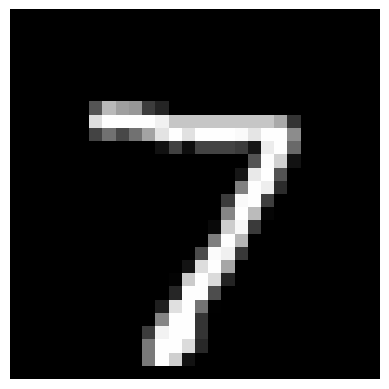

In [60]:
# We will now display the random digit image and its label
print("Label:", digit_label)
plt.imshow(digit_image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

This $7$ will be our target image from now on. First, we will define and apply the CNN layer to this input. For the parameters, though it would make sense to use $3\times3$ kernel which is equivalent to the eight-neighbour (1-hop) connectivity in our graph, we have found a different solution that involves using a $1\times1$ kernel, no padding, and a stride of $1$. 

Note below that we also manually define our weight initializer because we want it to be as similar as possible to the way the weights are initialized in the graph later. Finally, we will run the output of the `2DConv` layer through a `ReLU` activation function:

In [61]:
# We define a convolutional neural network with one convolutional layer and no pooling
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0, stride=1) # channels are set to 1 in both cases because we have a grayscale image
        nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')  # We specify the weight initialization as explained above
        self.fc1 = nn.Linear(in_features=1*28*28, out_features=10) # out_features is set to 10 because there are 10 digits in MNIST, though we won't attempt to classify here
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU is applied here
        x = x.view(-1, 1*28*28)
        x = self.fc1(x)
        return x

# We set the random seed again for reproducibility
torch.manual_seed(43) 

# We create an instance of the ConvNet model
model = ConvNet()

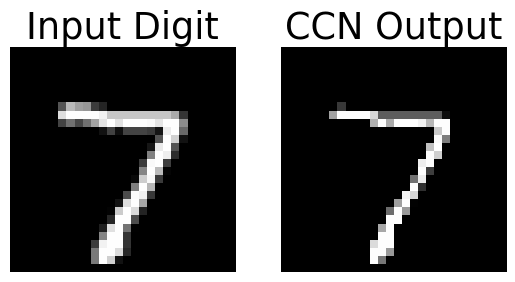

In [62]:
# We will now pass the digit image through the convolutional layer
digit_image.unsqueeze_(0)  
conv_output = model.conv1(digit_image)
conv_output = F.relu(conv_output)

# We can now visualize the output of the convolutional layer
fig, axs = plt.subplots(1, 2)
axs[0].imshow(digit_image.squeeze().numpy(), cmap='gray')
axs[0].set_title('Input Digit')
axs[1].imshow(conv_output[0, 0].detach().numpy(), cmap='gray')
axs[1].set_title('CCN Output')
for ax in axs:
    ax.axis('off')
plt.show()

The result of the CNN layer **without** pooling is shown above. We see that the $ 1 \times 1$ kernel has given us an output that is thinner than the original image. Let's see how we can replicate this with a GCN:

In [25]:
# First we define the rows, columns and nodes
n_rows = 28
n_cols = 28
n_nodes = n_rows * n_cols

# Now we initialize an empty adjacency matrix of only zeros
adj_matrix = np.zeros((n_nodes, n_nodes))

# We loop over each pixel and, wherever applicable, add edges to neighbors and update the adjacency matrix accordingly
for i in range(n_rows):
    for j in range(n_cols):
        node_id = i * n_cols + j

        if i > 0: # If node is not in first row
            if j > 0: # And if node is not in first column
                adj_matrix[node_id][node_id - n_cols - 1] = 1  # Add edge with top left diagonal neighbour
            adj_matrix[node_id][node_id - n_cols] = 1  # Add edge with top neighbour also
            if j < n_cols - 1: # if node is not in last column, additionally:
                adj_matrix[node_id][node_id - n_cols + 1] = 1  # Add edge with top right diagonal neighbour

        if j > 0: # If node is not in first column 
            adj_matrix[node_id][node_id - 1] = 1  # Add edge with left neighbour

        if j < n_cols - 1: # If node is not in last column
            adj_matrix[node_id][node_id + 1] = 1  # Add edge with right neighbour

        if i < n_rows - 1: # If node is not in last row
            if j > 0: # And node is not in first column
                adj_matrix[node_id][node_id + n_cols - 1] = 1  # Add edge with bottom left diagonal neighbour
            adj_matrix[node_id][node_id + n_cols] = 1  # Add edge with bottom neighbour also
            if j < n_cols - 1: # if node is not in last column, additionally 
                adj_matrix[node_id][node_id + n_cols + 1] = 1  # Add edge with bottom right diagonal neighbour

# Finally we will add self-loops
np.fill_diagonal(adj_matrix, 1)

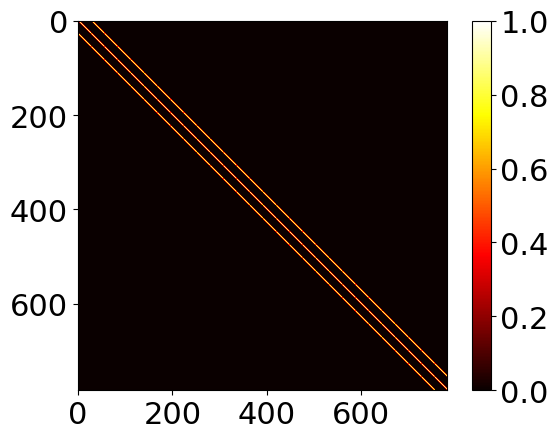

In [26]:
# We will now print the entire adjacency matrix to verify its shape
plt.imshow(adj_matrix, cmap='hot')
plt.colorbar()
plt.show()

The general composition of the adjacency matrix looks correct, but let's zoom in:

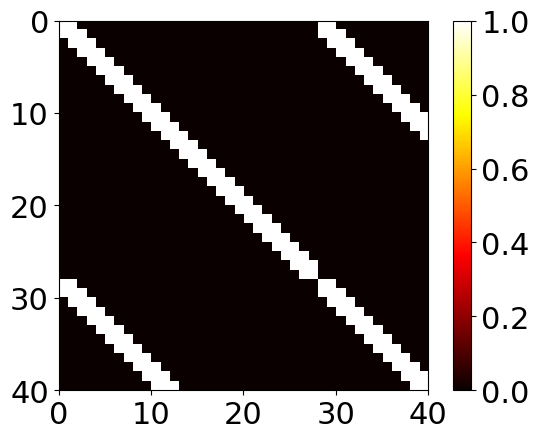

In [27]:
# We will print a subregion of the adjacency matrix to check further
plt.imshow(adj_matrix[:40, :40], cmap='hot', extent=[0, 40, 40, 0])
plt.colorbar()
plt.show()

Here we see that the self-loops have been encoded. Also based on the thickness of the secondary diagonals, it looks like we have encoded all 8 neighbours wherever applicable. Let's run one final check:

In [28]:
# We can verify that we have 4, 6 and 9 edges at three different key nodes
node_index = 0
num_edges = sum(adj_matrix[node_index])
print("Number of edges for node {}: {}".format(node_index, num_edges))

node_index = 20
num_edges = sum(adj_matrix[node_index])
print("Number of edges for node {}: {}".format(node_index, num_edges))

node_index = 30
num_edges = sum(adj_matrix[node_index])
print("Number of edges for node {}: {}".format(node_index, num_edges))

Number of edges for node 0: 4.0
Number of edges for node 20: 6.0
Number of edges for node 30: 9.0


Okay, including self-loops, we have 4 edges on the corner node, 6 on the border node and 9 for the last node. This is what we wanted and what was described earlier in Q2.1.

In [29]:
# We will now convert the adjacency matrix into a format that is "graph-able" by dgl
src, dst = np.nonzero(adj_matrix)
G = dgl.graph((src, dst))

<ipython-input-30-33796c04cd14>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G.ndata['x'] = torch.tensor(digit_image.reshape(-1, 1) / 255.0, dtype=torch.float32)


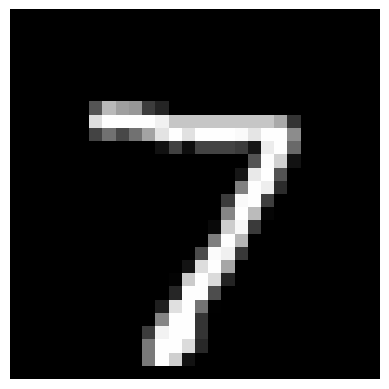

In [30]:
# We can now add grayscale values as node features
G.ndata['x'] = torch.tensor(digit_image.reshape(-1, 1) / 255.0, dtype=torch.float32)

# We reshape the node features to a 28x28 grid 
grid = G.ndata['x'].reshape((n_rows, n_cols))

# We display the grid as an image
plt.imshow(grid, cmap='gray')
plt.axis('off')
plt.show()

That looks identical to the original image, so it looks like we have defined our graph correctly. Let us now run our GCN layer:

In [31]:
# Verifying G edges have been encoded correctly
print(G)

Graph(num_nodes=784, num_edges=6724,
      ndata_schemes={'x': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})


Based on the number of edges in G, we can conclude that the adjacency matrix (6724) was passed into it correctly. Let's proceed:

In [32]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the GCN layer with Kaiming initialization and ReLU activation
gcn_layer = dgl.nn.GraphConv(1, 1, norm='both', weight=True, bias=True, activation=F.relu, allow_zero_in_degree=False)
nn.init.kaiming_uniform_(gcn_layer.weight, nonlinearity='relu')  # Kaiming initialization

Parameter containing:
tensor([[2.0331]], requires_grad=True)

Note above that we let the input and output features be $1$ as with the CNN. Additionally, we passed the same `ReLU` activation function and the same weight initializer. Also note that the adjacency matrix is normalized as explained in Q2.1 by using the `norm` parameter and setting it to `both`.

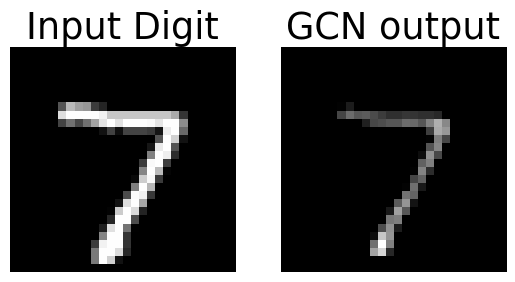

In [34]:
# We are ready to pass the graph through the GCN layer and collect the output features
output_feats = gcn_layer(G, G.ndata['x'])

# We reshape the output features into a 28x28 grid that is visualizable
output_grid = output_feats.detach().numpy().reshape((n_rows, n_cols))

# We visualize the output of the graph convolutional layer next to the original image
fig, axs = plt.subplots(1, 2)
axs[0].imshow(digit_image.squeeze().numpy(), cmap='gray')
axs[0].set_title('Input Digit')
axs[1].imshow(output_grid, cmap='gray')
axs[1].set_title('GCN output')
for ax in axs:
    ax.axis('off')
plt.show()


That looks quite similar to what we got with the CNN! Let us put both side by side to compare.

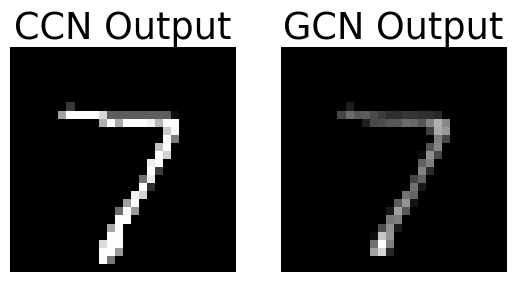

In [36]:
# Let's compare the output of the CNN and GCN layers
fig, axs = plt.subplots(1, 2)
axs[0].imshow(conv_output[0, 0].detach().numpy(), cmap='gray')
axs[0].set_title('CCN Output')
axs[1].imshow(output_grid, cmap='gray')
axs[1].set_title('GCN Output')
for ax in axs:
    ax.axis('off')
plt.show()

There are subtle differences which are likely due to the fact that the kernel in the CNN always performs an element-wise sum of convolved elements, whereas the aggregator function in the GCN is set to `AVERAGE` by default. That aside, we have proven that this is one of many ways to make the output of a CNN layer without pooling be very similar to the output of a GCN layer.

## Question 2.3: Conditions under which GraphConv and 2DConv are equivalent, assuming there **is no** 2D pooling after the 2D convolution.

Let's use the same principles to get two outputs that are as similar as possible when there is a 2DPooling layer involved:

In [42]:
# We once again define the transformation to apply to the input image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image
])

# We load the MNIST test dataset again
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# And we select the same digit from the test dataset
digit_idx = 0  # Index of the digit to select
digit_image, digit_label = test_dataset[digit_idx]

Label: 7


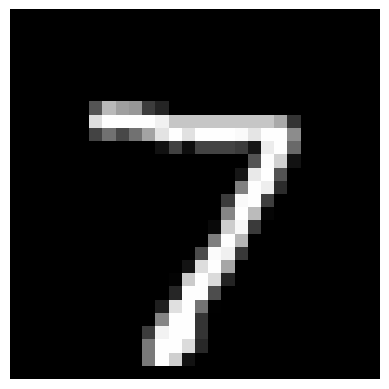

In [43]:
# We display the digit image and label again
print("Label:", digit_label)
plt.imshow(digit_image.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

Here is where the changes begin. Namely, we will add an `AvgPool2D` layer with a kernel of size $2$, no padding and a stride of size $1$. In addition, we will use a `Sigmoid` function instead of a `ReLU` function to make the smoothing effect of the pooling pop out more: 

In [44]:
# We define a convolutional neural network with one convolutional layer and one pooling layer
class ConvPoolNet(nn.Module):
    def __init__(self):
        super(ConvPoolNet, self).__init__()
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=1, padding=0, stride=1)
        nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='sigmoid')  # Kaiming initialization
        self.avgpool = nn.AvgPool2d(kernel_size=2, padding=0, stride=1) # here is where the pooling is defined
        self.fc2 = nn.Linear(in_features=1*28*28, out_features=10) 
        
    def forward(self, x):
        x = F.sigmoid(self.conv2(x)) # as mentioned, we will use sigmoid instead of ReLU
        x = self.avgpool(x)
        x = x.view(-1, 1*28*28)
        x = self.fc2(x)
        return x

# We set the random seed again
torch.manual_seed(43)

# Create an instance of the ConvNet model
model2 = ConvPoolNet()

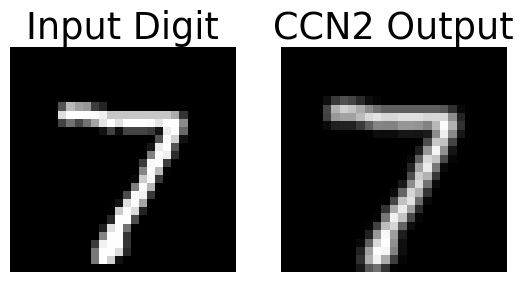

In [45]:
# We will pass the digit image through the convolutional layer and sigmoid activation function
digit_image.unsqueeze_(0)  
conv_output2 = model2.conv2(digit_image)
sigmoid_output = F.sigmoid(conv_output2)

# We will pass the sigmoid output through the pooling layer
conv_output2 = model2.avgpool(sigmoid_output)

# And now we can visualize the output of the pooling layer
fig, axs = plt.subplots(1, 2)
axs[0].imshow(digit_image.squeeze().numpy(), cmap='gray')
axs[0].set_title('Input Digit')
axs[1].imshow(conv_output2[0, 0].detach().numpy(), cmap='gray')
axs[1].set_title('CCN2 Output')
for ax in axs:
    ax.axis('off')
plt.show()

We have managed to blur/smoothen the edges by applying the changes to the CNN outlined right above. Let us proceed to generate a graph and GCN layer that produce a similar output.

The first step is to go from the 8-neighbour connectivity to the 4-neighbour connectivity when defining our new graph below: 

In [46]:
# We define the rows, cols and nodes as before
n_rows = 28
n_cols = 28
n_nodes = n_rows * n_cols

# We initialize adjacency matrix with zeros again
adj_matrix2 = np.zeros((n_nodes, n_nodes))

# We loop over each pixel and add edges to neighbors
for i in range(n_rows):
    for j in range(n_cols):
        node_id = i * n_cols + j

        if i > 0: # If node is not in first row
            adj_matrix2[node_id][node_id - n_cols] = 1  # Add top edge

        if j > 0: # If node is not in first column
            adj_matrix2[node_id][node_id - 1] = 1  # Add left edge

        if j < n_cols - 1: # If node is not in last column
            adj_matrix2[node_id][node_id + 1] = 1  # Add right edge

        if i < n_rows - 1: # If node is not in last row
            adj_matrix2[node_id][node_id + n_cols] = 1  # Add bottom edge

# And let's not forget the self-loops
np.fill_diagonal(adj_matrix2, 1)

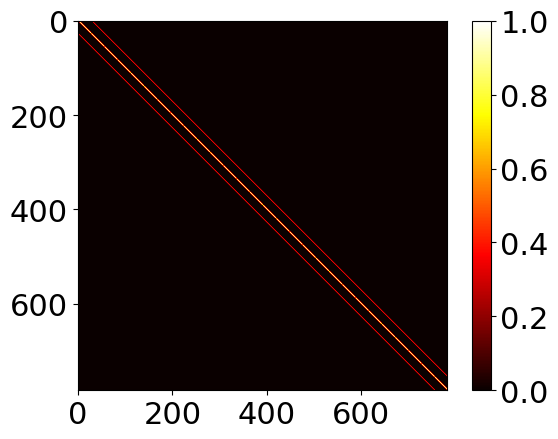

In [47]:
# Let's print the entire adjacency matrix to inspect it
plt.imshow(adj_matrix2, cmap='hot')
plt.colorbar()
plt.show()

It looks quite similar to the previous one from this perspective... Let's zoom in!

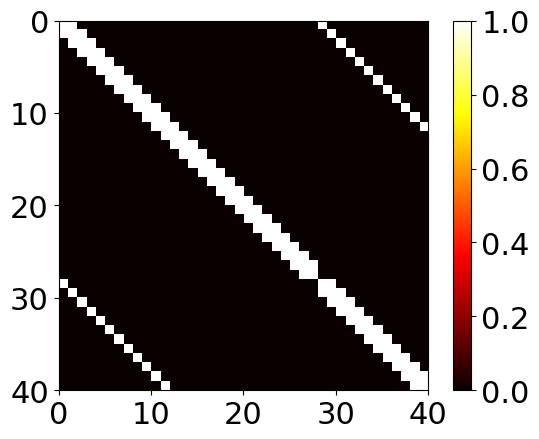

In [48]:
# Printing a subregion of the adjacency matrix
plt.imshow(adj_matrix2[:40, :40], cmap='hot', extent=[0, 40, 40, 0])
plt.colorbar()
plt.show()

Here we see by the thickness of the secondary diagonals that we have less edges per row/column. Looks like we defined the 4-neighbour connectivity correctly, but let us perform one last test to make sure:

In [49]:
# Verifying that we have 3, 4 and 5 edges at key nodes
node_index = 0
num_edges = sum(adj_matrix2[node_index])
print("Number of edges for node {}: {}".format(node_index, num_edges))

node_index = 20
num_edges = sum(adj_matrix2[node_index])
print("Number of edges for node {}: {}".format(node_index, num_edges))

node_index = 30
num_edges = sum(adj_matrix2[node_index])
print("Number of edges for node {}: {}".format(node_index, num_edges))

Number of edges for node 0: 3.0
Number of edges for node 20: 4.0
Number of edges for node 30: 5.0


Okay, that settles it. Let us now define our graph:

In [50]:
# We will now convert the adjacency matrix into a format that is "graph-able" by dgl like we did in Q2.2
src2, dst2 = np.nonzero(adj_matrix2)
G2 = dgl.graph((src2, dst2))

<ipython-input-51-87700c77ec0d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G2.ndata['x'] = torch.tensor(digit_image.reshape(-1, 1) / 255.0, dtype=torch.float32)


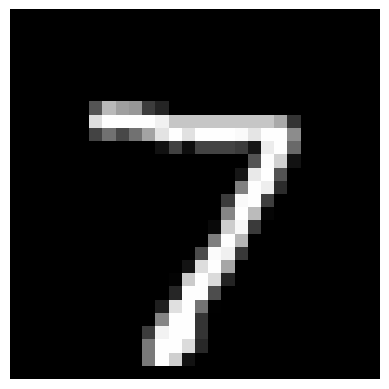

In [51]:
# We will add the grayscale values as node features as before
G2.ndata['x'] = torch.tensor(digit_image.reshape(-1, 1) / 255.0, dtype=torch.float32)

# We reshape the node features to a 28x28 grid
grid2 = G2.ndata['x'].reshape((n_rows, n_cols))

# And we display the image grid again
plt.imshow(grid2, cmap='gray')
plt.axis('off')
plt.show()

We get the same image as before, which is good. Now, onto the new GCN layer:

In [52]:
# Let us verify that the G2 edges have been defined correctly
print(G2)

Graph(num_nodes=784, num_edges=3808,
      ndata_schemes={'x': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={})


Our graph has way less edges now (3808), so we know that the adjacency matrix was correctly loaded into the graph.

In [53]:
# We set random seed for reproducibility
torch.manual_seed(42)

# We define the GCN layer with Kaiming initialization as before and tanh activation function this time
gcn_layer2 = dgl.nn.GraphConv(1, 1, norm='both', weight=True, bias=True, activation=F.tanh, allow_zero_in_degree=False)
nn.init.kaiming_uniform_(gcn_layer.weight, nonlinearity='tanh')  # Kaiming initialization

# We pass the graph through the GCN layer
output_feats2 = gcn_layer2(G2, G2.ndata['x'])

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Only one thing has changed above: the choice of activation function, which is now TanH instead of ReLU. Let's see the results:

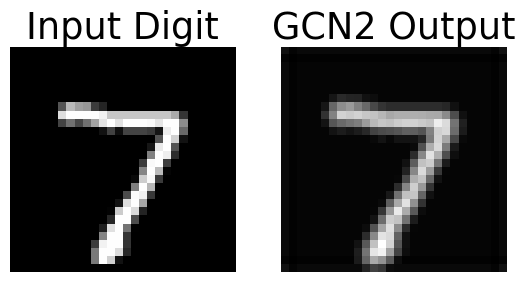

In [54]:
# We reshape the output features into a 28x28 image grid
output_grid2 = output_feats2.detach().numpy().reshape((n_rows, n_cols))

# We are ready to visualize the output of the convolutional layer
fig, axs = plt.subplots(1, 2)
axs[0].imshow(digit_image.squeeze().numpy(), cmap='gray')
axs[0].set_title('Input Digit')
axs[1].imshow(output_grid2, cmap='gray')
axs[1].set_title('GCN2 Output')
for ax in axs:
    ax.axis('off')
plt.show()


Looks like we managed to replicate the smoothing we performed with the CNN! Let's put the two side by side to make sure though:

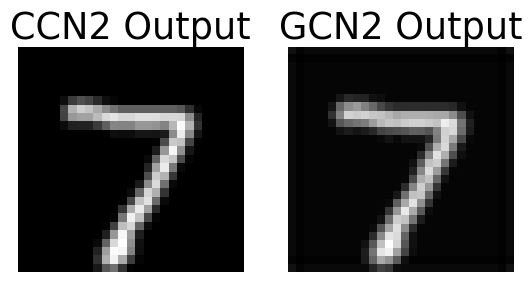

In [55]:
# We will finish by comparing the output of the CNN and GCN layers
fig, axs = plt.subplots(1, 2)
axs[0].imshow(conv_output2[0, 0].detach().numpy(), cmap='gray')
axs[0].set_title('CCN2 Output')
axs[1].imshow(output_grid2, cmap='gray')
axs[1].set_title('GCN2 Output')
for ax in axs:
    ax.axis('off')
plt.show()

Here we have proven that it is also possible to make the output of a 2DConv + 2DPool layer in a CNN equivalent to a single GCN layer simply by tweaking some parameters. More specifically, by choosing different activation functions, adding a bit of average pooling to the CNN, and making the neighbourhood for each graph node more restrictive, we managed to get an image that's not as sharp as the input using both algorithms.